In [19]:
import sys
sys.path.append("../libs/")

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import shift_data, print_hp,print_line, graficarTodo, split_df, graficarClases, plot_metrics, plot_cm, plot_roc, plot_prc, plot_probs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import datetime
import os
import keras_tuner as kt
from keras_tuner import HyperModel
import keras.metrics as metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, GRU
from keras.losses import BinaryCrossentropy

# Carga de datos

In [21]:
df = pd.read_csv('../data/USA_DATA_DIFF.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 552 entries, 1976-12-01 to 2022-11-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   INDPRO     552 non-null    float64
 1   PAYEMS     552 non-null    float64
 2   UNRATENSA  552 non-null    float64
 3   MPRIME     552 non-null    float64
 4   TOTALSA    552 non-null    float64
 5   Class      552 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 30.2 KB


In [23]:
df.describe()

,INDPRO,PAYEMS,UNRATENSA,MPRIME,TOTALSA,Class
count,552.000000,552.000000,552.000000,552.000000,5.520000e+02,552.000000
mean,0.001504,0.001188,0.001758,-0.000092,-6.503275e-07,0.115942
std,0.003272,0.001763,0.017313,0.018738,8.059840e-03,0.320446
min,-0.012309,-0.006452,-0.096487,-0.051722,-3.474568e-02,0.000000
25%,0.000322,0.000509,-0.003765,-0.009446,-3.181993e-03,0.000000
50%,0.002075,0.001442,0.005265,0.000082,7.457537e-04,0.000000
75%,0.003471,0.002111,0.009246,0.013065,5.037476e-03,0.000000
max,0.008630,0.004349,0.054615,0.048879,1.919342e-02,1.000000


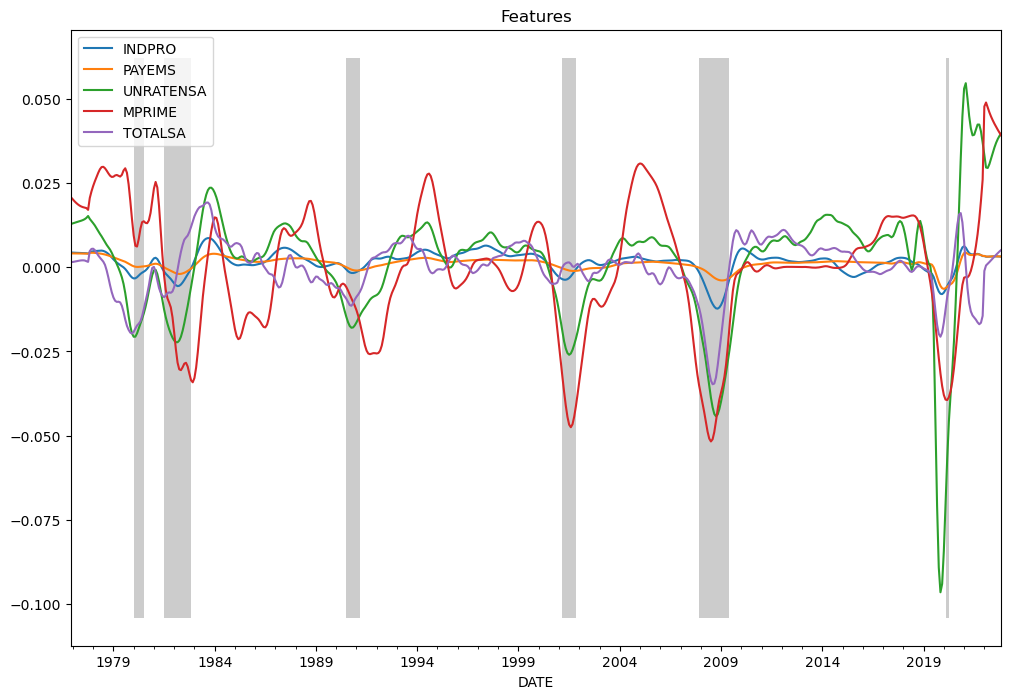

In [24]:
graficarTodo(df,'Features')

# Mostrar Imbalance de clases

In [25]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 552
    Positive: 64 (11.59% of total)



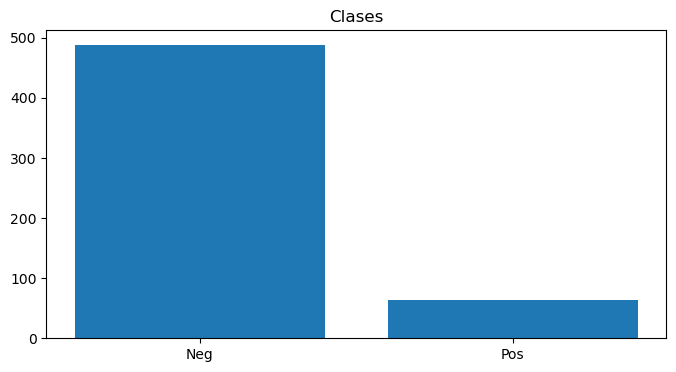

In [26]:
graficarClases(df['Class'])

In [27]:
initial_bias = np.log([pos/neg])

In [28]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.57
Weight for class 1: 4.31


# Dividir Datos

In [29]:
target_col = ['Class']
features = df.columns[(df.columns!=target_col[0])]
df_train, df_test = split_df(df,0.2)

# Normalizar

In [30]:
df_x_train = df_train[features].copy()
df_y_train = df_train[target_col].copy()
df_x_test = df_test[features].copy()
df_y_test = df_test[target_col].copy()

scaler = StandardScaler()

df_x_train.iloc[:,:] = scaler.fit_transform(df_x_train)
df_x_test.iloc[:,:] = scaler.transform(df_x_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)

# Construccion

## Modelo

In [31]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def build_gru(n_steps_in: int, n_features: int, gru_cells: int,
                gru_dropout : float, dense_layers : int, dense_nodes : int, 
                dense_dropout : float, learning_rate: float, dense_activation = None,
                metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = Constant(output_bias)
    model = Sequential()
    model.add(GRU(gru_cells, input_shape=(n_steps_in, n_features)))
    model.add(Dropout(gru_dropout))
    for i in range(dense_layers):
        model.add(Dense(dense_nodes, activation=dense_activation))
    model.add(Dropout(dense_dropout))
    model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=BinaryCrossentropy(), metrics=metrics)
    return model

## Optimizador

In [32]:
class GRUHyperModel(HyperModel):

    def __init__(self, n_features_in,n_steps_out, output_bias = None, class_weight= None, name = None, tunable = True):
        super().__init__(name=name, tunable=tunable)
        self.n_features = n_features_in
        self.n_steps_out = n_steps_out
        self.output_bias = output_bias
        self.class_weight = class_weight

    def build(self, hp):
        # Parametrizamos nro de capas, nro de nodos y ratio de aprendizaje
        hp_time_steps = hp.Int('steps_in',4,10,step=1)
        hp_gru_cells = hp.Int('gru_cells',32,356,step=16)
        hp_gru_dropout = hp.Float('gru_dropout',0.1,0.5,step=0.1)
        hp_dense_layers = hp.Int('dense_layers',1,5,step=1)
        hp_dense_nodes = hp.Int('dense_nodes',32,356,step=16)
        hp_dense_dropout = hp.Float('dense_dropout',0.1,0.5,step=0.1)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        hp_dense_activation = hp.Choice('dense_activation', values=['relu','tanh'])

        return build_gru(
            n_steps_in = hp_time_steps,
            n_features = self.n_features,
            gru_cells = hp_gru_cells,
            gru_dropout = hp_gru_dropout,
            dense_layers = hp_dense_layers,
            dense_nodes = hp_dense_nodes,
            dense_dropout = hp_dense_dropout,
            learning_rate = hp_learning_rate,
            dense_activation = hp_dense_activation,
            output_bias=initial_bias
        )
        
    def fit(self, hp, model,x,y,**kwargs):
        x_s,y_s = shift_data(x, y, hp.get('steps_in'), self.n_steps_out)
        #mini_batch = 32
        batch_learning = len(x_s)
        return model.fit(x = x_s, y = y_s, batch_size = batch_learning, class_weight=self.class_weight, **kwargs)

In [44]:
n_steps_out = [1,6,12]
n_features = len(features)
ajuste_path = os.path.normpath('G:/')
fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M')
objective = kt.Objective('val_precision',direction='max')
max_epochs = 30
n_epochs = 50

In [34]:
output_path = 'ajustes/'
output_path_model = 'modelos/'
name_prj = 'GRU_USA_'
N = 20


In [42]:
def optimizar_y_entrenar(name_prj, n_steps_out):
    name_prj = name_prj + str(n_steps_out) +'_'+fecha_hora
    name_model_tun = output_path+name_prj+'.h5'
    # Condicion de parada: 10 epocas despues del menor val_loss
    es = EarlyStopping(
        monitor='val_precision', 
        verbose=0,
        patience=10,
        mode='max',
        restore_best_weights=True)
    
    # --------------------- Optimizacion --------------------------------------
    gru_hypermodel = GRUHyperModel(n_features, n_steps_out, class_weight = class_weight) # output_bias=initial_bias

    gru_tuner = kt.Hyperband(
        gru_hypermodel,
        objective = objective,
        max_epochs = max_epochs,
        #directory = ajuste_path,
        project_name = name_prj,
        overwrite=True)

    print("Optimizando...")
    gru_tuner.search(x = df_x_train, y = df_y_train, validation_split = 0.3, epochs = n_epochs
        , verbose = 2, shuffle = False, callbacks = [es])

    # guardar parametros de mejor modelo
    best_gru_hps = gru_tuner.get_best_hyperparameters(num_trials = 1)[0]
    print_hp(output_path+name_prj+'.txt',gru_tuner)

    gru_model = gru_tuner.hypermodel.build(best_gru_hps)
    gru_model.save(name_model_tun) # modelo sin entrenar
    print(best_gru_hps.values)

    # --------------------- Entrenamiento --------------------------------------
    n_steps_in = best_gru_hps.get('steps_in')
    x_train, y_train = shift_data(df_x_train, df_y_train, n_steps_in, n_steps_out)
    x_test, y_test = shift_data(df_x_test, df_y_test, n_steps_in, n_steps_out)
    batch_learning = len(x_train)

    prcs = []
    models = []
    res_path = output_path_model+name_prj+".csv"
    print_line("loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc\n",res_path)

    print("Entrenando...")
    for i in range(N):
        name_model = output_path_model+name_prj+'_'+str(i)+'.h5'
        gru_model = load_model(name_model_tun)
        # Condicion de parada: 10 epocas despues del menor val_loss
        es_t = EarlyStopping(
            monitor='val_precision', 
            verbose=0,
            patience=10,
            mode='max',
            restore_best_weights=True)
        models.append(name_model)
        history = gru_model.fit(x=x_train, y=y_train, validation_split = 0.3, epochs = n_epochs
            , verbose = 0, shuffle = False, callbacks = [es_t], batch_size = batch_learning, class_weight=class_weight)

        gru_model.save(name_model) 
        # --------------------- Evaluacion --------------------------------------
        res = gru_model.evaluate(x_test, y_test,
                                        batch_size=batch_learning, verbose=0)
        print_line(f'{res[0]},{res[1]},{res[2]},{res[3]},{res[4]},{res[5]},{res[6]},{res[7]},{res[8]},{res[9]}\n', res_path)
        prcs.append(res[9]) #guarda metrica a comparar

    #--------- Evaluando el mejor ------------------------
    print("Evaluando...")
    best_model = models[np.argmax(prcs)]
    print(f'\nMejor modelo: {best_model} con prc: {np.max(prcs)}\n')

    gru_model = load_model(best_model)
    train_predictions = gru_model(x_train) #, batch_size=batch_learning
    test_predictions = gru_model(x_test)

    plot_cm(y_test, test_predictions)
    plot_roc(y_train, train_predictions, y_test, test_predictions)
    plot_prc(y_train, train_predictions, y_test, test_predictions)
    plot_probs(y_train, train_predictions, 'Train')
    plot_probs(y_test, test_predictions, 'Test')

# Modelo para 1 mes a futuro

Trial 90 Complete [00h 00m 03s]
val_precision: 0.0

Best val_precision So Far: 1.0
Total elapsed time: 00h 04m 27s
INFO:tensorflow:Oracle triggered exit
{'steps_in': 6, 'gru_cells': 144, 'gru_dropout': 0.30000000000000004, 'dense_layers': 3, 'dense_nodes': 192, 'dense_dropout': 0.2, 'learning_rate': 0.001, 'dense_activation': 'tanh', 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
Entrenando...
Evaluando...

Mejor modelo: modelos/GRU_USA_1_20221230_0144_0.h5 con prc: 0.9041059613227844

Expansiones Detectadas (Verdadero Negativos):  95
Expansiones Incorrecas Detectadas (Falso Positivos):  6
Recesiones no Detectadas (False Negativos):  0
Recesiones Detectadas (Verdadero Positivos):  3
Total de Recesiones:  3


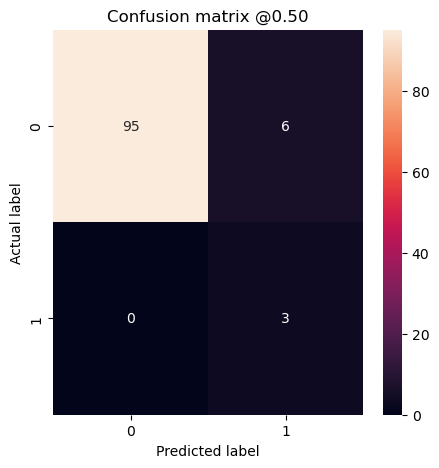

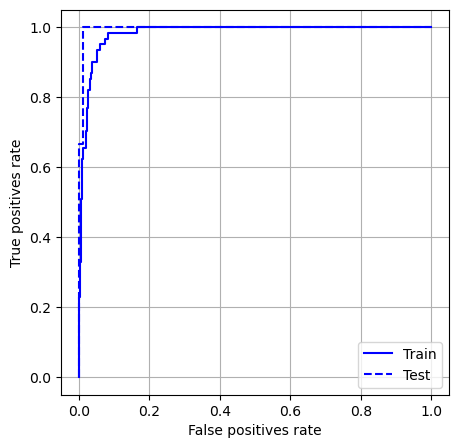

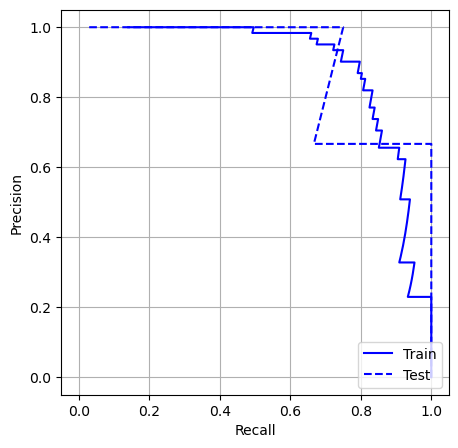

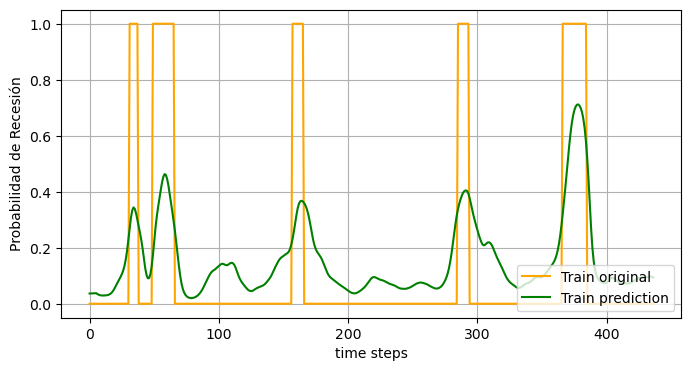

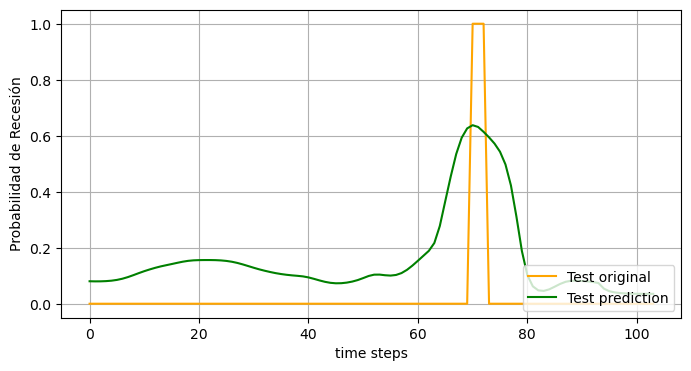

In [45]:
optimizar_y_entrenar(name_prj, n_steps_out[0])

# Modelo para 6 meses a futuro

Trial 90 Complete [00h 00m 04s]
val_prc: 0.648932933807373

Best val_prc So Far: 0.8774733543395996
Total elapsed time: 00h 04m 32s
INFO:tensorflow:Oracle triggered exit
{'steps_in': 6, 'gru_cells': 112, 'gru_dropout': 0.30000000000000004, 'dense_layers': 4, 'dense_nodes': 288, 'dense_dropout': 0.5, 'learning_rate': 0.0001, 'dense_activation': 'tanh', 'tuner/epochs': 4, 'tuner/initial_epoch': 2, 'tuner/bracket': 3, 'tuner/round': 1, 'tuner/trial_id': '0029'}
Entrenando...
Evaluando...

Mejor modelo: modelos/GRU_USA_6_20221230_0110_17.h5 con prc: 0.38538631796836853

Expansiones Detectadas (Verdadero Negativos):  76
Expansiones Incorrecas Detectadas (Falso Positivos):  20
Recesiones no Detectadas (False Negativos):  0
Recesiones Detectadas (Verdadero Positivos):  3
Total de Recesiones:  3


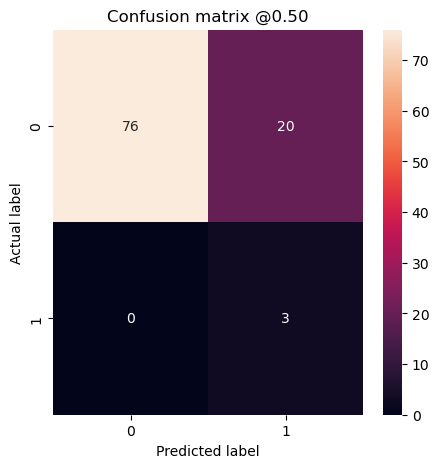

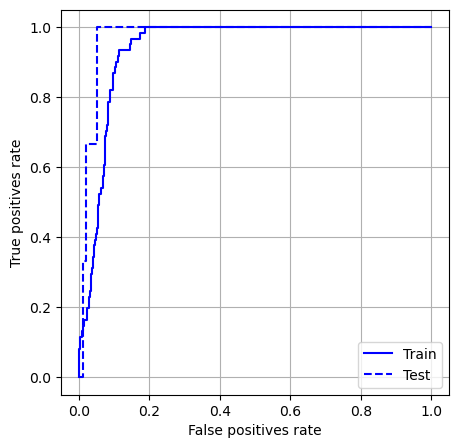

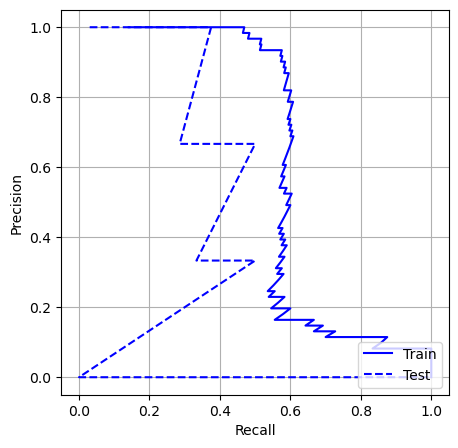

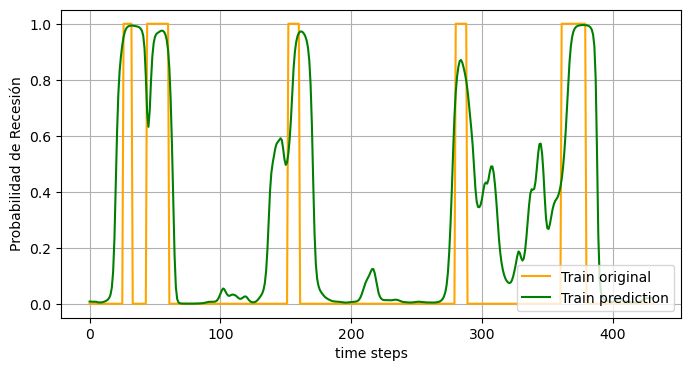

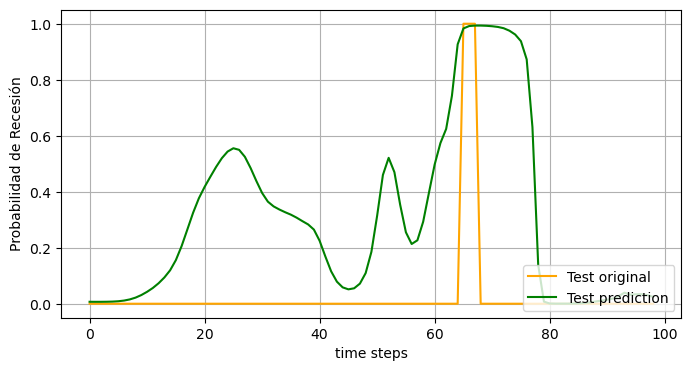

In [37]:
optimizar_y_entrenar(name_prj, n_steps_out[1])

# Modelo para 12 meses a futuro

Trial 90 Complete [00h 00m 04s]
val_prc: 0.22142022848129272

Best val_prc So Far: 0.6594867706298828
Total elapsed time: 00h 04m 28s
INFO:tensorflow:Oracle triggered exit
{'steps_in': 9, 'gru_cells': 32, 'gru_dropout': 0.4, 'dense_layers': 2, 'dense_nodes': 64, 'dense_dropout': 0.5, 'learning_rate': 0.0001, 'dense_activation': 'tanh', 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
Entrenando...
Evaluando...

Mejor modelo: modelos/GRU_USA_12_20221230_0110_6.h5 con prc: 0.04173053056001663

Expansiones Detectadas (Verdadero Negativos):  39
Expansiones Incorrecas Detectadas (Falso Positivos):  48
Recesiones no Detectadas (False Negativos):  0
Recesiones Detectadas (Verdadero Positivos):  3
Total de Recesiones:  3


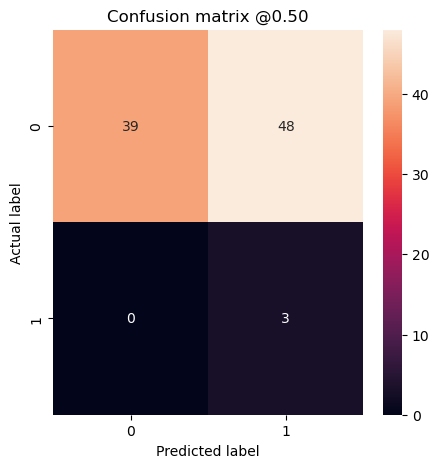

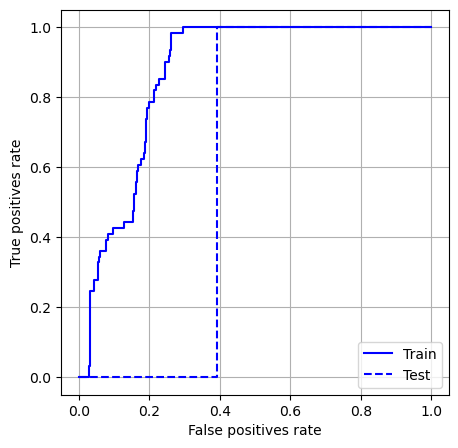

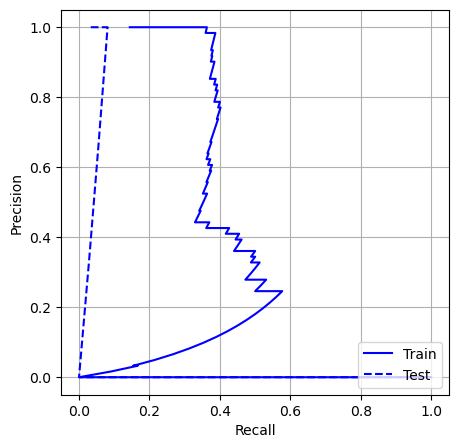

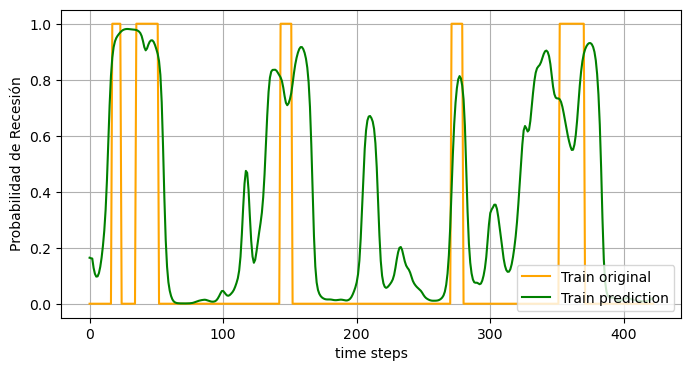

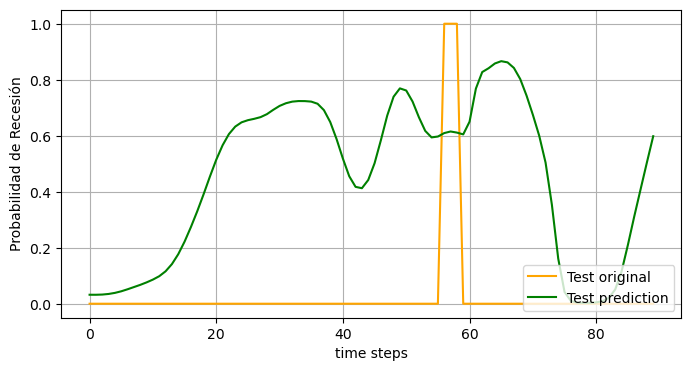

In [38]:
optimizar_y_entrenar(name_prj, n_steps_out[2])